In [ ]:
# Convert raw captions into dataframe

data = []

with open("/content/captions.txt", "r") as f:
    lines = f.readlines()

skipped = 0
for line in lines:
    parts = line.strip().split(" ",1)
    if len(parts) != 2:
        skipped += 1
        print(f"Skipping malformed line: {line}")
        continue  # or log: print(f"Skipping malformed line: {line}")
    image_id, caption = parts
    image = image_id.split("#")[0]
    data.append((image, caption.strip()))

print(f"Skipped {skipped} malformed lines.")

import pandas as pd
df = pd.DataFrame(data, columns=["image", "caption"])
df.head()


Skipping malformed line: image,caption

Skipping malformed line: 2199200615.jpg,

Skipped 2 malformed lines.


,image,caption
0,"1000092795.jpg,",Two young guys with shaggy hair look at their ...
1,"1000092795.jpg,""","Two young , White males are outside near many ..."
2,"1000092795.jpg,",Two men in green shirts are standing in a yard .
3,"1000092795.jpg,",A man in a blue shirt standing in a garden .
4,"1000092795.jpg,",Two friends enjoy time spent together .


In [ ]:
# Generate CSV files using the dataframes

import pandas as pd

# 1. Load captions
captions = pd.read_csv("/content/Flickr8k.token.txt", sep="\t", names=["image_id", "caption"])
captions["image"] = captions["image_id"].apply(lambda x: x.split("#")[0])

# 2. Load split image lists
def load_image_list(filepath):
    with open(filepath, "r") as f:
        return [line.strip() for line in f.readlines()]

train_imgs = load_image_list("/content/Flickr_8k.trainImages.txt")
val_imgs = load_image_list("/content/Flickr_8k.devImages.txt")
test_imgs = load_image_list("/content/Flickr_8k.testImages.txt")

# 3. Filter captions by split
train_df = captions[captions["image"].isin(train_imgs)]
val_df = captions[captions["image"].isin(val_imgs)]
test_df = captions[captions["image"].isin(test_imgs)]

# 4. Save CSVs
train_df.to_csv("flickr8k_train.csv", index=False)
val_df.to_csv("flickr8k_val.csv", index=False)
test_df.to_csv("flickr8k_test.csv", index=False)

In [ ]:
df.to_csv("flickr30k_all_captions.csv",index=False)

In [ ]:
# split into Train/Validation/Test (80/10/10)

from sklearn.model_selection import train_test_split

unique_images = df["image"].unique()
train_imgs, temp_imgs = train_test_split(unique_images, test_size=0.2, random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

def save_split(ids, name):
    split_df = df[df["image"].isin(ids)]
    split_df.to_csv(f"flickr30k_{name}.csv", index=False)

save_split(train_imgs, "train")
save_split(val_imgs, "val")
save_split(test_imgs, "test")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
flickr8k_dir = "/content/drive/MyDrive/CapstoneProject/Datasets/Flickr8k_images"
flickr8k_csv_dir = "/content/drive/MyDrive/CapstoneProject/Datasets/Flickr8k_text"
flickr30k_dir = "/content/drive/MyDrive/CapstoneProject/Datasets/Flickr30k_images"
flickr30k_csv_dir = "/content/drive/MyDrive/CapstoneProject/Datasets/Flickr30k_captions"
output_dir = "/content/drive/MyDrive/CapstoneProject/Embeddings"

In [ ]:
# Load CLIP Model and Processor
!pip install transformers ftfy
import torch
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
from PIL import Image
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Functions for getting embeddings

def get_image_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)
    return outputs.cpu().numpy().squeeze()

def get_text_embeddings(captions):
    inputs = processor(text=captions, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        outputs = model.get_text_features(**inputs)
    return outputs.cpu().numpy()

In [ ]:
# Function to generate embeddings

def generate_clip_embeddings(csv_file, img_dir, split_name, output_dir):
    df = pd.read_csv(csv_file, names=["image", "caption"], quoting=3, on_bad_lines='skip', engine='python')
    #df = pd.read_csv(csv_file)
    grouped = df.groupby("image")

    image_embs = []
    text_embs = []
    image_found = 0

    for img_name, group in tqdm(grouped):
        img_path = os.path.join(img_dir, img_name)
        if not os.path.exists(img_path):
            print(f"Missing: {img_path}")
            continue
        image_found += 1
        try:
            image_emb = get_image_embedding(img_path)
            text_emb = get_text_embeddings(group["caption"].tolist())

            image_embs.append(image_emb)
            text_embs.extend(text_emb)
        except Exception as e:
            print(f"Error with {img_name}: {e}")
            continue

    print(f"Processed {image_found} images.")

    np.save(os.path.join(output_dir, f"{split_name}_image_embs.npy"), image_embs)
    np.save(os.path.join(output_dir, f"{split_name}_text_embs.npy"), text_embs)

In [ ]:
# Genrate embeddings for train/test/val

generate_clip_embeddings(
    csv_file= flickr8k_csv_dir + "/flickr8k_train.csv",
    img_dir= flickr8k_dir,
    split_name="flickr8k_train",
    output_dir=output_dir
)

generate_clip_embeddings(
    csv_file= flickr8k_csv_dir + "/flickr8k_val.csv",
    img_dir= flickr8k_dir,
    split_name="flickr8k_val",
    output_dir=output_dir
)

generate_clip_embeddings(
    csv_file= "/content/drive/MyDrive/CapstoneProject/Datasets/Flickr30k_captions/flickr30k_val.csv",
    img_dir= flickr30k_dir,
    split_name="flickr30k_val",
    output_dir=output_dir
)

100%|██████████| 3256/3256 [41:38<00:00,  1.30it/s]

Missing: /content/drive/MyDrive/CapstoneProject/Datasets/Flickr30k_images/image
Processed 3255 images.


In [ ]:
# Helper function to split the 30k dataset into multiple chunks

import pandas as pd
import math

# Load the full train CSV
csv_file = "/content/drive/MyDrive/CapstoneProject/Datasets/Flickr30k_captions/flickr30k_train.csv"
df = pd.read_csv(csv_file, names=["image", "caption"], quoting=3, on_bad_lines='skip', engine='python')
#df = pd.read_csv("/content/drive/MyDrive/CapstoneProject/Datasets/Flickr30k_captions/flickr30k_train.csv")

# Get all unique image names
unique_images = df["image"].unique()
chunk_size = 5000

# Split into chunks of ~5k images
image_chunks = [unique_images[i:i + chunk_size] for i in range(0, len(unique_images), chunk_size)]
print(f"Total chunks: {len(image_chunks)}")

Total chunks: 6


In [ ]:
# Code to generate embeddings for each chunk

for i, img_batch in enumerate(image_chunks):
    chunk_df = df[df["image"].isin(img_batch)]
    chunk_df.to_csv(f"/content/drive/MyDrive/CapstoneProject/Datasets/Flickr30k_captions/flickr30k_train_chunk_{i}.csv", index=False)

    # Then pass this CSV to your existing embedding function
    generate_clip_embeddings(
        csv_file=f"/content/drive/MyDrive/CapstoneProject/Datasets/Flickr30k_captions/flickr30k_train_chunk_{i}.csv",
        img_dir="/content/drive/MyDrive/CapstoneProject/Datasets/Flickr30k_images",
        split_name=f"flickr30k_train_chunk_{i}",
        output_dir="/content/drive/MyDrive/CapstoneProject/Embeddings"
    )

  0%|          | 1/5000 [02:00<166:38:40, 120.01s/it]

Missing: /content/drive/MyDrive/CapstoneProject/Datasets/Flickr30k_images/1000092795.jpg


100%|██████████| 5000/5000 [1:25:39<00:00,  1.03s/it]


Missing: /content/drive/MyDrive/CapstoneProject/Datasets/Flickr30k_images/image
Processed 4998 images.


 29%|██▉       | 1466/5001 [25:06<1:00:32,  1.03s/it]


KeyboardInterrupt: 

In [ ]:
# Load & Normalize Embeddings

# Load
image_embs = np.load("/content/drive/MyDrive/CapstoneProject/Embeddings/flickr8k_train_image_embs.npy")
text_embs = np.load("/content/drive/MyDrive/CapstoneProject/Embeddings/flickr8k_train_text_embs.npy")
df = pd.read_csv(flickr8k_csv_dir+"/flickr8k_train.csv")

# Normalize
def normalize(vectors):
    return vectors / np.linalg.norm(vectors, axis=1, keepdims=True)

image_embs = normalize(image_embs)
text_embs = normalize(text_embs)

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 57.0 MB/s eta 0:00:00


In [ ]:
# Create FAISS index for image embeddings
import faiss

index = faiss.IndexFlatIP(image_embs.shape[1])
index.add(image_embs)

In [ ]:
top_k = 5
scores, indices = index.search(text_embs, top_k)

In [ ]:
# Assume captions are ordered: 5 captions per image, in order
# So caption 0–4 → image 0, 5–9 → image 1, etc.
correct_image_indices = np.repeat(np.arange(len(image_embs)), 5)

# Check if correct index is in top K results
recall_at_k = (correct_image_indices[:, None] == indices).any(axis=1).mean()
print(f"Recall@{top_k}: {recall_at_k:.4f}")

Recall@5: 0.5696


In [ ]:
for k in [1, 5, 10]:
    r_at_k = (correct_image_indices[:, None] == indices[:, :k]).any(axis=1).mean()
    print(f"Recall@{k}: {r_at_k:.4f}")

Recall@1: 0.5482
Recall@5: 0.8174
Recall@10: 0.8174


Query: A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .


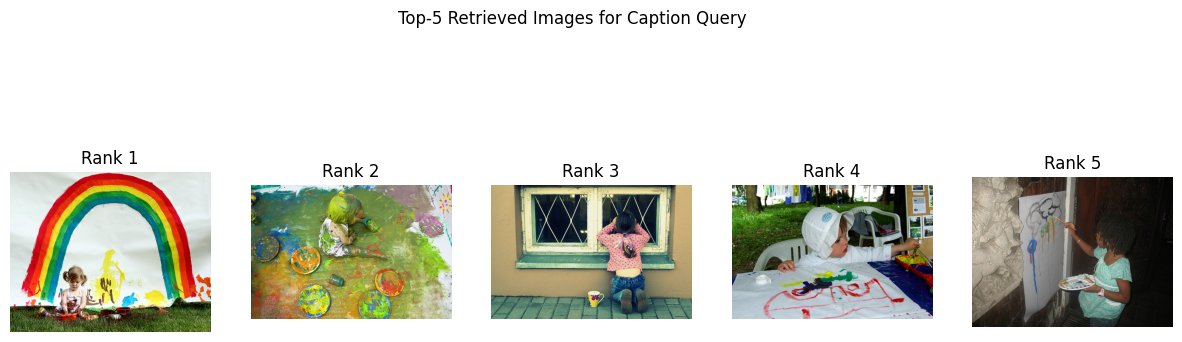

In [ ]:
# Verification of Image retrieval for top 5

sample_idx = 10 # sample caption index
query_caption = df.iloc[sample_idx]["caption"]
query_image = df.iloc[sample_idx]["image"]
print(f"Query: {query_caption}")

# Get matching text embedding
query_text_vector = text_embs[sample_idx:sample_idx+1]  # shape (1, 512)

# Search top 5 similar images
scores, indices = index.search(query_text_vector, 5)
top_images = df["image"].unique()[indices[0]]

image_dir = flickr8k_dir

plt.figure(figsize=(15, 5))
for i, img_name in enumerate(top_images):
    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path)

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Rank {i+1}")

plt.suptitle("Top-5 Retrieved Images for Caption Query")
plt.show()